# Google Colab dependencies
Below are some additional dependencies that are required if we are running this file on google colab editor. Box2D-py has some installation issues on Windows hence I have used google colab. 

In [0]:
%%capture
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install box2d box2d-kengz

!apt-get install python-opengl -y
!apt install xvfb -y

# For rendering environment, you can use pyvirtualdisplay.
!pip install pyvirtualdisplay
!pip install piglet

# To activate virtual display 
# need to run a script once for training an agent as follows
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)"
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

# Import required libraries

In [2]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random

import keras
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model


import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation

Using TensorFlow backend.


# DQN
Here we have functions for tranining the deep Q-learning nerual network for Lunar Lander game. 

In [0]:
class DQN(object):
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):
        '''
        Parameters: 
          env: OpenAI Gym environment
          action_space: Discrete action space of size (4x1)
          observation_space: State space of size (8x1)
          lr: Learning rate
          gamma: Discount factor
          epilson_decay: Decay parameter for greedy exploration 
          replay_memory_buffer: Buffer size for experience replay max size 500000
          batch_size: Batch size for training
          num_action_space: Total no. of actions 
          num_observation_space: Total no. of states
          model: Q-value target network
          epsilon_min: Minimum greedy parameter
          rewards_list: Array for storing avergae rewards 
        '''
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.replay_memory_size = 500000
        self.global_count = 0
        self.update_target_estimator_every = 10000
        self.replay_memory_init_size = 50000
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model, self.target_model = self.initialize_model()

    def initialize_model(self):
        '''
        initialize_model: 
          Here we initialize our neural network. 
        Neural Network Architecture:
          Input Layer: 8 x 1
          Hidden Layer 1: 512 x 256
          Hidden Layer 2: 256 x 4
          Output Layer: 4 x 1
        Activation function in hidden layers is ReLU and output layer is linear
        We minimize the mean squared error and we do gradient descent using Adam Optimizer
        '''
        model = Sequential()
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())

        # Clone the model
        target_model = keras.models.clone_model(model)
        target_model.build()
        target_model.set_weights(model.get_weights())

        return model, target_model

    def get_action(self, state):
        '''
        get_action: 
          In this function we take action based on epsilon-greedy 
          exploration i.e. with some probability we take random action or we take 
          action that will give us maximum Q-value.
        '''
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)

        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        '''
        add_to_replay_memory: 
          This function adds all the information for each time step
          in the replay buffer.
        '''
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):
        '''
        learn_and_update_weights_by_reply:
          This function is used to update the weights and do early stopping 
          to prevent overfitting.
        '''

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.target_model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.target_model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1000, verbose=0)
        self.global_count += 1000

    def get_attribues_from_sample(self, random_sample):
        '''
        get_attributes_from_sample:
          If we have sample from the replay buffer, then we will extract 
          some key feature of that sample.
        '''
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        '''
        get_random_sample_from_mem:
          This function extracts different random samples from the replay 
          memory buffer.
        '''
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train(self, num_episodes=2000, can_stop=True):
        # Populate the replay memory with initial experience
#         print("Populating replay memory...")
        state = env.reset()
        state = np.reshape(state, [1, self.num_observation_space])
        # for i in range(10):
        for i in range(self.replay_memory_init_size):
            env.render()
            received_action = self.get_action(state)
            next_state, reward, done, info = env.step(received_action)
            next_state = np.reshape(next_state, [1, self.num_observation_space])
            # Store the experience in replay memory
            self.add_to_replay_memory(state, received_action, reward, next_state, done)
            state = next_state
            if done:
                state = env.reset()
                state = np.reshape(state, [1, self.num_observation_space])
        env.close()
#         print("Done populating replay memory...")

        for episode in range(num_episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, self.num_observation_space])

            for step in range(num_steps):
                # Update the target estimator
                if self.global_count % self.update_target_estimator_every == 0:
                    self.target_model.set_weights(self.model.get_weights())
                # Take step in the env  
                env.render()
                received_action = self.get_action(state)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                # If our replay memory is full, pop the first element
                if len(self.replay_memory_buffer) == self.replay_memory_size:
                    self.replay_memory_buffer.pop(0)
                # Store the experience in replay memory
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                # add up rewards
                reward_for_episode += reward
                state = next_state
                self.learn_and_update_weights_by_reply()

                if done:
                    break
            self.rewards_list.append(reward_for_episode)

            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Check for breaking condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 200 and can_stop:
                print("DQN Training Complete...")
                break
            if episode%1 == 0:
                print('-'*30)
                print('Episode: ', episode)
                print('Reward: ', reward_for_episode)
                print('Average Reward: ', last_rewards_mean)
                print('Epsilon: ', self.epsilon)
                print('-'*30)

    def save(self, name):
        self.model.save(name)


# Main loop
Here we will train our Deep Q-learning neural network.

In [4]:
env = gym.make('LunarLander-v2')
env = wrap_env(env)

# set seeds
env.seed(21)
np.random.seed(21)

# setting up params
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99
training_episodes = 2000
print('Start traning the DQN for Lunar Lander')
model = DQN(env, lr, gamma, epsilon, epsilon_decay)
model.train(training_episodes, True)

Start traning the DQN for Lunar Lander




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None






Populating replay memory...
Done populating replay memory...


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




------------------------------
Episode:  0
Reward:  -352.27721832581364
Average Reward:  -352.27721832581364
Epsilon:  0.995
------------------------------
------------------------------
Episode:  1
Reward:  -350.9128345966742
Average Reward:  -351.59502646124395
Epsilon:  0.990025
------------------------------
------------------------------
Episode:  2
Reward:  -97.47776907051316
Average Reward:  -266.88927399766703
Epsilon:  0.985074875
------------------------------
------------------------------
Episode:  3
Reward:  -136.96125928072362
Average Reward:  -234.4072703184312
Epsilon:  0.9801495006250001
------------------------------
------------------------------
Episode:  4
Reward:  -318.82178646465604
Average Reward:  -251.29017354767615
Epsilon:  0.9752487531218751
------------------------------
------------------------------
Episode:  5
Reward:  -114.97234579412081
Average Reward:  -228.5705355887503
Epsilon:  0.9703725093562657
------------------------------
------------------

# Performance Testing
Below are functions requried to test our model and see its performance during testing and training. 

In [0]:
def test_already_trained_model(trained_model):
    rewards_list = []
    num_test_episode = 100
    env = gym.make("LunarLander-v2")
    print("Starting Testing of the trained model...")

    step_count = 1000

    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        if test_episode%20 == 0:
            print('Episode: ', test_episode, 'Reward: ', reward_for_episode)
            return rewards_list

def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df['rolling_mean'] = df[df.columns[0]].rolling(100).mean()
    plt.figure(figsize=(8, 6))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1.5, figsize=(8, 6), title=title)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    # plt.ylim((-400, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(False)
    fig.savefig(chart_name)


def plot_df2(df, chart_name, title, x_axis_label, y_axis_label):
    df['mean'] = df[df.columns[0]].mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(8, 6))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1.5, figsize=(8, 6), title=title)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((0, 300))
    plt.xlim((0, 100))
    plt.legend().set_visible(False)
    fig = plot.get_figure()
    fig.savefig(chart_name)

# Save the model

In [0]:
# Save Everything
save_dir = "saved_models"
# Save trained model
model.save(save_dir + "trained_model.h5")

# Save Rewards list
pickle.dump(model.rewards_list, open(save_dir + "train_rewards_list.p", "wb"))
rewards_list = pickle.load(open(save_dir + "train_rewards_list.p", "rb"))

# Plot the rewards

<Figure size 432x288 with 0 Axes>

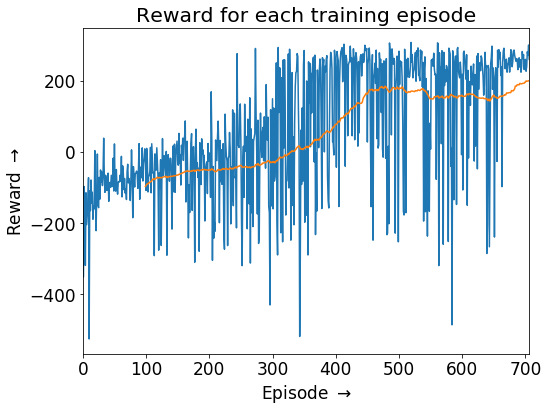

In [7]:
# Plot reward in graph
# Orange line corresponds to avergae of 100 episodes
reward_df = pd.DataFrame(rewards_list)
plot_df(reward_df, "Figure 1: Reward for each training episode", "Reward for each training episode", 
        r"Episode $\rightarrow$", r"Reward $\rightarrow$")

# Plot moving avergae of rewards

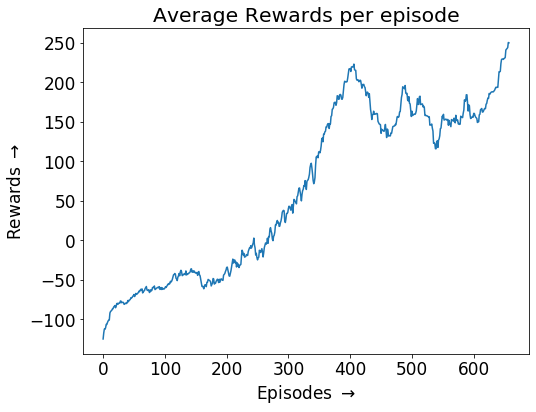

In [8]:
def moving_average(a, n):
    '''
    Function for doing moving window average
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]/n


reward_df = pd.DataFrame(rewards_list)
reward_np = np.array(reward_df)
reward_np_avg = moving_average(reward_np, 50)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(reward_np_avg)), reward_np_avg)
plt.xlabel(r'Episodes $\rightarrow$')
plt.ylabel(r'Rewards $\rightarrow$')
plt.title('Average Rewards per episode')
plt.savefig('Fig3.jpeg')
plt.show()

# Performance measure
Here we will test our trained model observe its score over 100 episodes.

Starting Testing of the trained model...
Episode:  0 Reward:  294.3157948470219
Episode:  20 Reward:  259.7218851121137
Episode:  40 Reward:  0.9525046643134374
Episode:  60 Reward:  247.89710605693486
Episode:  80 Reward:  268.7599069316197
Training and Testing Completed...!


<Figure size 432x288 with 0 Axes>

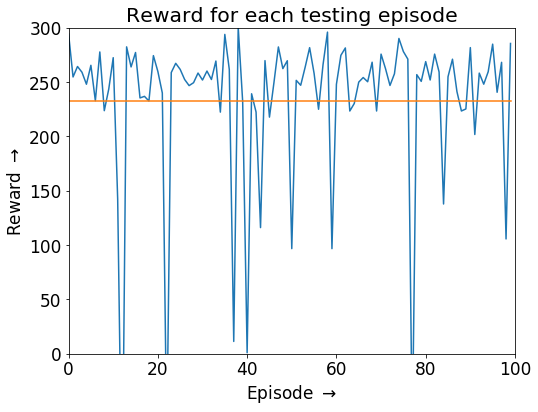

In [9]:
# Test the model
trained_model = load_model(save_dir + "trained_model.h5")
test_rewards = test_already_trained_model(trained_model)
pickle.dump(test_rewards, open(save_dir + "test_rewards.p", "wb"))
test_rewards = pickle.load(open(save_dir + "test_rewards.p", "rb"))

plot_df2(pd.DataFrame(test_rewards), "Figure 2: Reward for each testing episode", "Reward for each testing episode", 
         r"Episode $\rightarrow$", r"Reward $\rightarrow$")
print("Training and Testing Completed...!")

# Video
Here we will generate the video for the Lunar Lander using the trained DQN network. We will save it as mp4 and gif. 

In [10]:
trained_model = load_model(save_dir + "trained_model.h5")
rewards_list = []
num_test_episode = 1
env = gym.make("LunarLander-v2")
env = wrap_env(env)
print("Generating video...")

step_count = 1000
frames = []

current_state = env.reset()
num_observation_space = env.observation_space.shape[0]
current_state = np.reshape(current_state, [1, num_observation_space])
reward_for_episode = 0
for step in range(step_count):
    # env.render()
    frames.append(env.render(mode = 'rgb_array'))
    selected_action = np.argmax(trained_model.predict(current_state)[0])
    new_state, reward, done, info = env.step(selected_action)
    new_state = np.reshape(new_state, [1, num_observation_space])
    current_state = new_state
    reward_for_episode += reward
    if done:
        break
rewards_list.append(reward_for_episode)
print("Reward: ", reward_for_episode)

Generating video...
Reward:  249.45136018535925


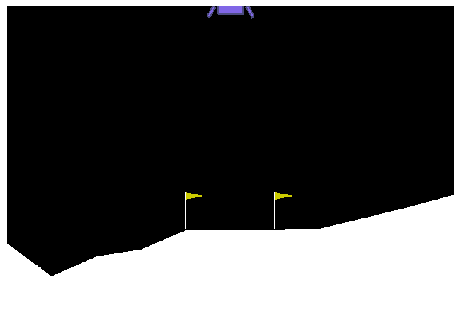

In [11]:
# Real! Lunar Lander Video
plt.figure(figsize=(8, 6))
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 25)
HTML(ani.to_jshtml())

In [0]:
# Save animation in the format of mp4 and gif
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('LunarLander.gif', writer=animation.PillowWriter(25))
ani.save('LunarLander.mp4', writer=writer)